In [1]:
from a_star.data_util import get_posed_rgbd_dataset
import torch
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as V
import sys
sys.path.append('voxel_map')
from voxel import VoxelizedPointcloud
import clip
import numpy as np
import tqdm
import torch.nn.functional as F
import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_inv_intrinsics(intrinsics):
    # return intrinsics.double().inverse().to(intrinsics)
    fx, fy, ppx, ppy = intrinsics[..., 0, 0], intrinsics[..., 1, 1], intrinsics[..., 0, 2], intrinsics[..., 1, 2]
    inv_intrinsics = torch.zeros_like(intrinsics)
    inv_intrinsics[..., 0, 0] = 1.0 / fx
    inv_intrinsics[..., 1, 1] = 1.0 / fy
    inv_intrinsics[..., 0, 2] = -ppx / fx
    inv_intrinsics[..., 1, 2] = -ppy / fy
    inv_intrinsics[..., 2, 2] = 1.0
    return inv_intrinsics


def apply_pose(xyz, pose):
    return (torch.einsum("na,nba->nb", xyz.to(pose), pose[..., :3, :3]) + pose[..., :3, 3]).to(xyz)


def apply_inv_intrinsics(xy, intrinsics):
    inv_intrinsics = get_inv_intrinsics(intrinsics)
    xyz = torch.cat((xy, torch.ones_like(xy[..., :1])), dim=-1)
    return torch.einsum("na,nba->nb", xyz.to(inv_intrinsics), inv_intrinsics)

def get_xyz_coordinates_from_xy(depth, xy, pose, intrinsics):
    xyz = apply_inv_intrinsics(xy, intrinsics)
    xyz = xyz * depth[:, None]
    xyz = apply_pose(xyz, pose)
    return xyz

def get_xyz_coordinates(depth, mask, pose, intrinsics):

    bsz, _, height, width = depth.shape
    flipped_mask = ~mask

    # Associates poses and intrinsics with XYZ coordinates.
    batch_inds = torch.arange(bsz, device=mask.device)
    batch_inds = batch_inds[:, None, None, None].expand_as(mask)[~mask]
    intrinsics = intrinsics[batch_inds]
    pose = pose[batch_inds]

    # Gets the depths for each coordinate.
    depth = depth[flipped_mask]

    # Gets the pixel grid.
    xs, ys = torch.meshgrid(
        torch.arange(width, device=depth.device),
        torch.arange(height, device=depth.device),
        indexing="xy",
    )
    xy = torch.stack([xs, ys], dim=-1)[None, :, :].repeat_interleave(bsz, dim=0)
    xy = xy[flipped_mask.squeeze(1)]

    return get_xyz_coordinates_from_xy(depth, xy, pose, intrinsics)

In [3]:
def find_alignment_over_model(queries):
    clip_text_tokens = model.encode_text(clip.tokenize(queries).to(device)).float()
    points, features, _, _ = voxel_pcd.get_pointcloud()
    features = F.normalize(features, p=2, dim=-1).detach().cpu().float()
    point_alignments = clip_text_tokens.detach().cpu() @ features.T
    return points[point_alignments.topk(k = 1, dim = -1).indices].reshape(-1, 3)

In [4]:
def forward_one_block(resblocks, x):
    q, k, v = None, None, None
    y = resblocks.ln_1(x)
    y = F.linear(y, resblocks.attn.in_proj_weight, resblocks.attn.in_proj_bias)
    N, L, C = y.shape
    y = y.view(N, L, 3, C//3).permute(2, 0, 1, 3).reshape(3*N, L, C//3)
    y = F.linear(y, resblocks.attn.out_proj.weight, resblocks.attn.out_proj.bias)
    q, k, v = y.tensor_split(3, dim=0)
    v += x
    v = v + resblocks.mlp(resblocks.ln_2(v))

    return v

def run_mask_clip(clip_model, x, image_shape):
    with torch.no_grad():
        x = clip_model.visual.conv1(x)
        N, L, H, W = x.shape
        x = x.reshape(x.shape[0], x.shape[1], -1)
        x = x.permute(0, 2, 1)
        x = torch.cat([clip_model.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)
        x = x + clip_model.visual.positional_embedding.to(x.dtype)
        x = clip_model.visual.ln_pre(x)
        x = x.permute(1, 0, 2)
        for idx in range(clip_model.visual.transformer.layers):
            if idx == clip_model.visual.transformer.layers - 1:
                break
            x = clip_model.visual.transformer.resblocks[idx](x)
        x = forward_one_block(clip_model.visual.transformer.resblocks[-1], x)
        x = x[1:]
        x = x.permute(1, 0, 2)
        x = clip_model.visual.ln_post(x)
        x = x @ clip_model.visual.proj
        feat = x.reshape(N, H, W, -1).permute(0, 3, 1, 2)
    feat = F.interpolate(feat, image_shape, mode = 'bilinear', align_corners = True)
    feat = F.normalize(feat, dim = 1)
    return feat.permute(0, 2, 3, 1)

In [5]:
dataset = get_posed_rgbd_dataset('r3d', 'Kitchen.r3d')

from a_star.map_util import get_ground_truth_map_from_dataset
ground_truth_map = get_ground_truth_map_from_dataset(
    dataset, 0.1, (0.1, 1.5)
)
minx, miny = ground_truth_map.origin
(ycells, xcells), resolution = ground_truth_map.grid.shape, ground_truth_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution

Occupancy Map: 100%|████████████████████████████████████████████████████████████| 1148/1148 [00:02<00:00, 529.78it/s]


In [6]:
import sys
from omegaconf import OmegaConf
sys.path.append("voxel_map")
from voxel_map_localizer import VoxelMapLocalizer
from voxel_map_localizer_v2 import VoxelMapLocalizerV2
from dataloaders import (
    R3DSemanticDataset,
    OWLViTLabelledDataset,
    OWLViTLabelledDatasetV2
)

cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load('v2' + cfg.cache_path)

semantic_memory = load_dataset(cfg)

torch.Size([13, 23253])


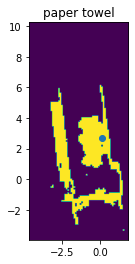

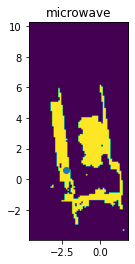

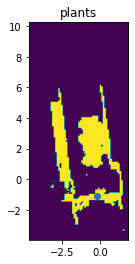

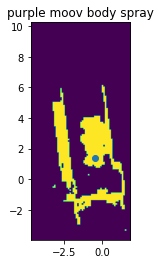

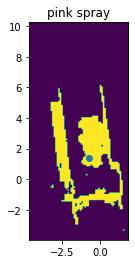

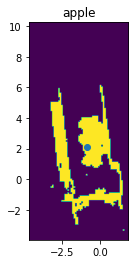

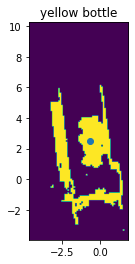

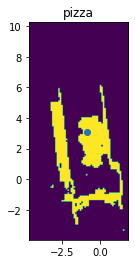

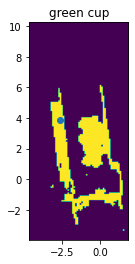

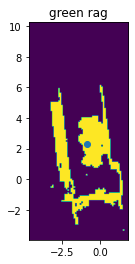

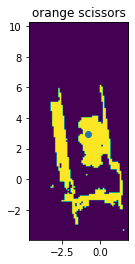

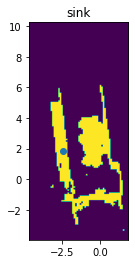

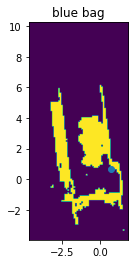

In [46]:
localizer = VoxelMapLocalizerV2(
        semantic_memory,
        owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
labels = ['paper towel', 'microwave', 'plants', 'purple moov body spray', 'pink spray', 'apple', 'yellow bottle', 'pizza', 'green cup', 'green rag', 'orange scissors', 'sink', 'blue bag']
pred_xyzs = localizer.find_alignment_for_A(labels)

for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.title(labels[idx])
    plt.show()

In [47]:
memory_chris = torch.load('memory_chris.pt')
memory_mahi = torch.load('memory_mahi.pt')

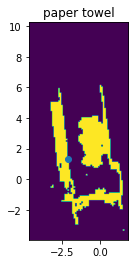

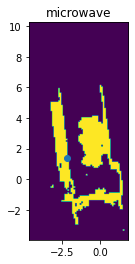

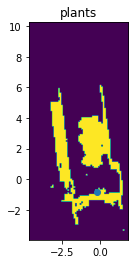

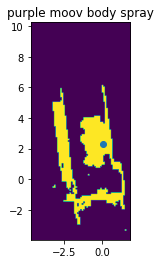

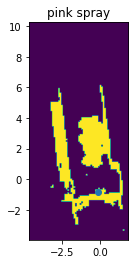

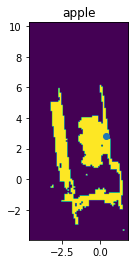

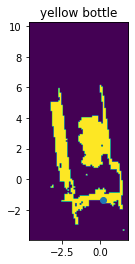

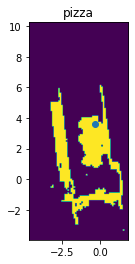

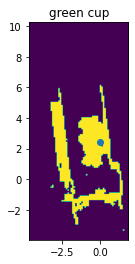

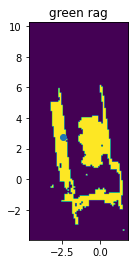

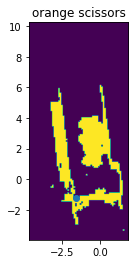

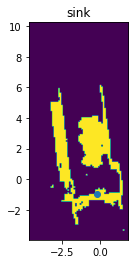

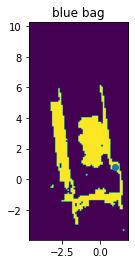

In [48]:
voxel_pcd = memory_chris
device = "cuda"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.eval()
pred_xyzs = find_alignment_over_model(labels)

for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.title(labels[idx])
    plt.show()

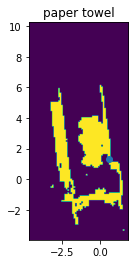

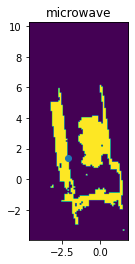

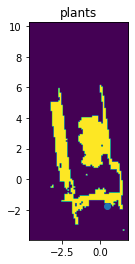

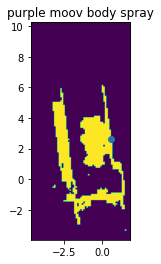

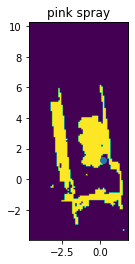

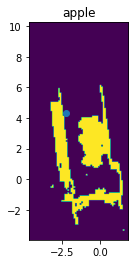

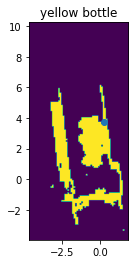

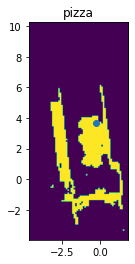

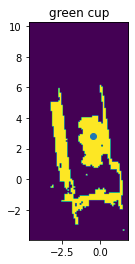

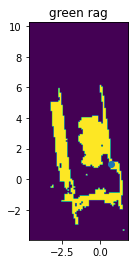

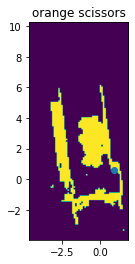

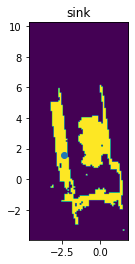

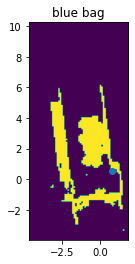

In [49]:
voxel_pcd = memory_mahi
device = "cuda"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.eval()
pred_xyzs = find_alignment_over_model(labels)

for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.title(labels[idx])
    plt.show()

# Scene 1 evaluation

In [5]:
dataset = get_posed_rgbd_dataset('r3d', '/data/peiqi/r3d/VenkyRoom.r3d')

from a_star.map_util import get_ground_truth_map_from_dataset
ground_truth_map = get_ground_truth_map_from_dataset(
    dataset, 0.1, (-0.7, 1.0)
)
minx, miny = ground_truth_map.origin
(ycells, xcells), resolution = ground_truth_map.grid.shape, ground_truth_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution

Occupancy Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1139/1139 [03:27<00:00,  5.50it/s]


In [6]:
annotations = pd.read_csv('venkyroom.csv')
labels = list(annotations['query'].values)
xyzs = torch.stack([torch.from_numpy(annotations['x'].values), torch.from_numpy(annotations['y'].values), torch.from_numpy(annotations['z'].values)], dim = -1)
afford = torch.from_numpy(annotations['affordance'].values)

## OK-Robot (OWL-ViT features)

In [7]:
import sys
from omegaconf import OmegaConf
sys.path.append("voxel_map")
from voxel_map_localizer import VoxelMapLocalizer
from voxel_map_localizer_v2 import VoxelMapLocalizerV2
from dataloaders import (
    R3DSemanticDataset,
    OWLViTLabelledDataset,
    OWLViTLabelledDatasetV2
)

In [8]:
cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load(cfg.cache_path)

semantic_memory = load_dataset(cfg)
localizer = VoxelMapLocalizer(
        semantic_memory,
        owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
for idx, label in enumerate(labels):
    labels[idx] = label 
    
pred_xyzs = localizer.find_alignment_for_A(labels)
pred_xs, pred_zs, neg_pred_ys = pred_xyzs.unbind(-1)
pred_xyzs = torch.stack([pred_xs, -neg_pred_ys, pred_zs], dim = -1)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

torch.Size([32, 22590])


0.4375

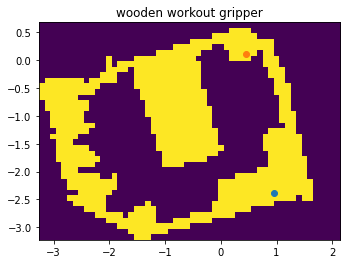

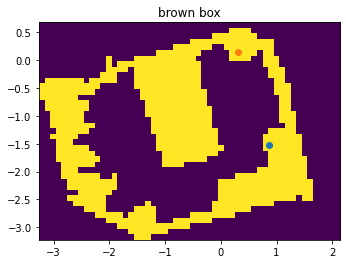

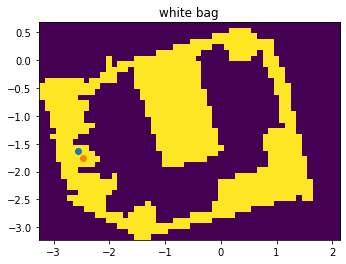

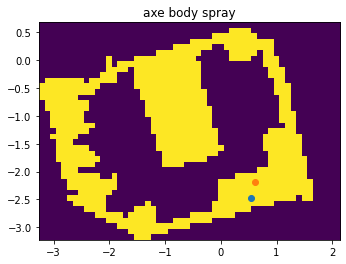

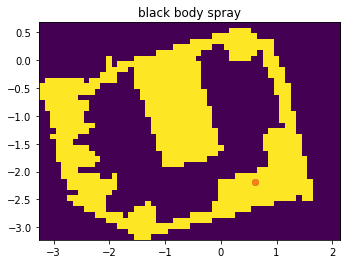

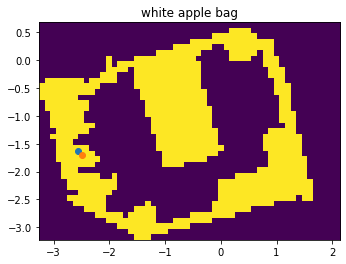

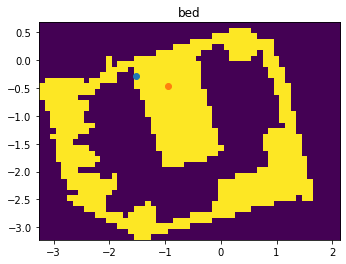

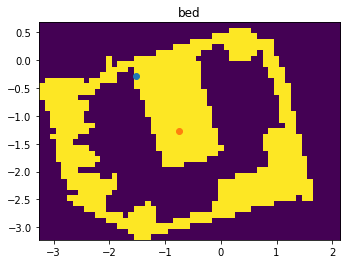

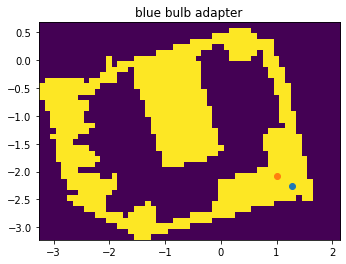

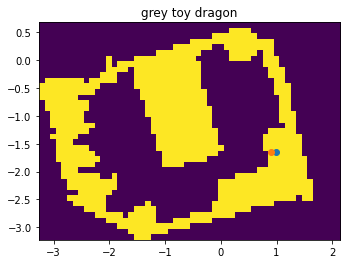

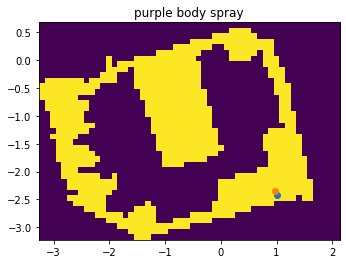

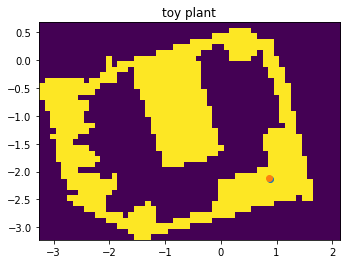

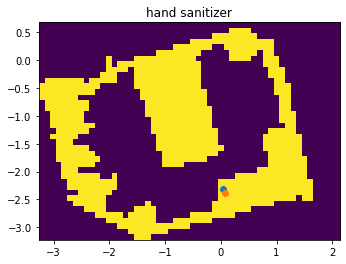

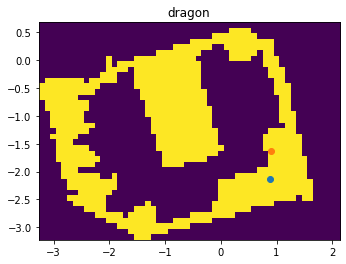

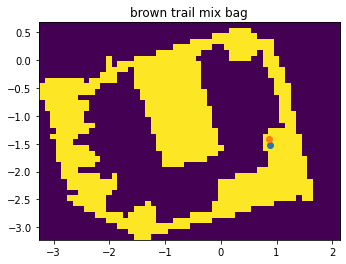

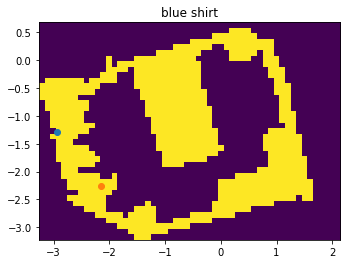

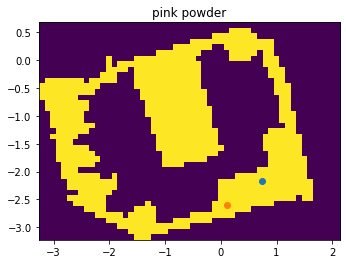

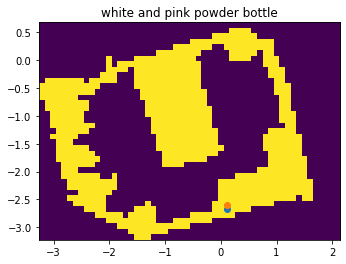

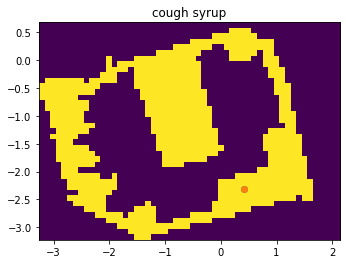

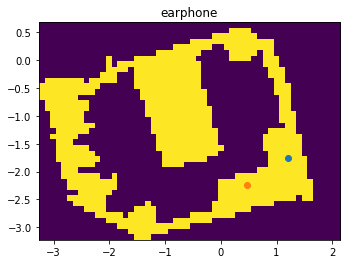

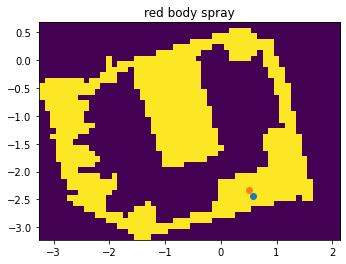

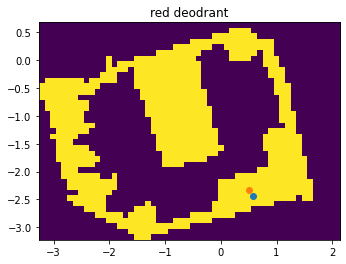

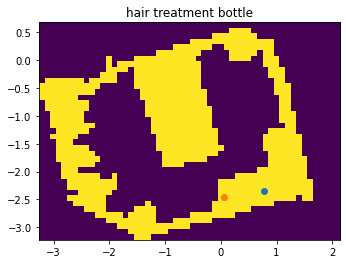

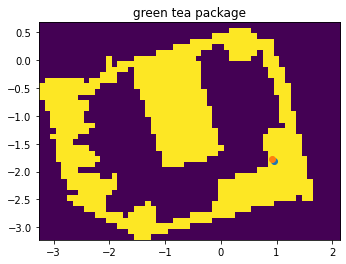

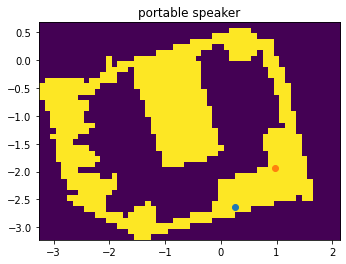

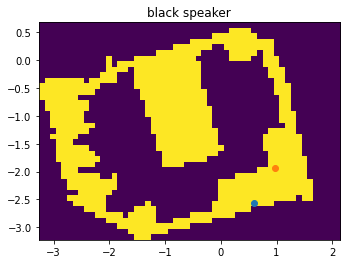

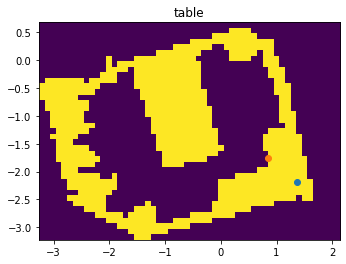

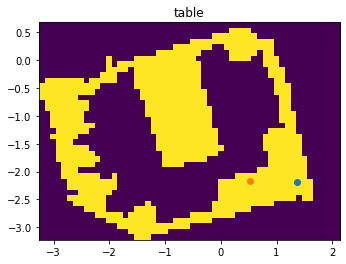

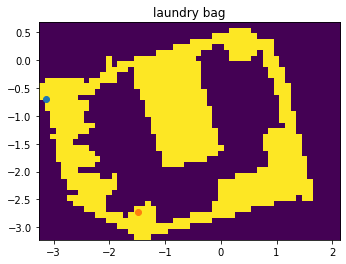

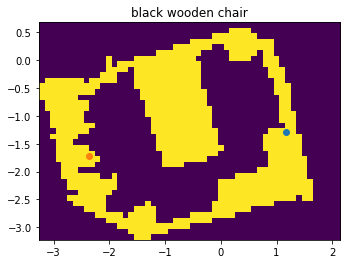

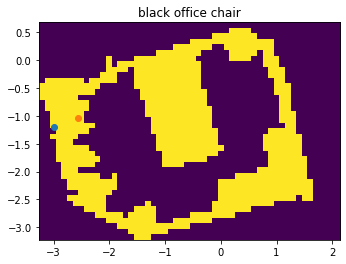

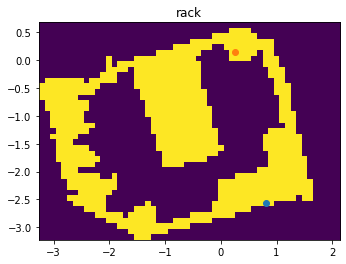

In [9]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

## MaskCLIP

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import AutoProcessor, OwlViTForObjectDetection
import clip
from torchvision import transforms

from dataloaders.scannet_200_classes import CLASS_LABELS_200
import time
import torch.nn.functional as F

device = 'cuda'
processor = AutoProcessor.from_pretrained("google/owlvit-base-patch32")
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").eval().to(device)
sam = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')
mask_predictor = SamPredictor(sam)
mask_predictor.model = mask_predictor.model.eval().to(device)
model, preprocess = clip.load('ViT-B/32', device = device)
model = model.eval()

In [ ]:
rgb, depth, mask, intrinsics, pose = dataset[300]
# texts = [list(CLASS_LABELS_200)]
# for idx, text in enumerate(texts[0]):
#     texts[0][idx] = 'a photo of ' + texts[0][idx]
texts = [['a photo of green box'], ['a photo of speaker'], ['a photo of plant']]

start_time = time.time()

with torch.no_grad():
    inputs = processor(text=texts, images=(rgb * 255).int(), return_tensors="pt")
    for input in inputs:
        inputs[input] = inputs[input].to(device)
    outputs = owl_model(**inputs)
    target_sizes = torch.Tensor([rgb.size()[1:][::-1]]).to(device)
    results = processor.post_process_object_detection(outputs=outputs, threshold=0.1, target_sizes=target_sizes)

    owl_time = time.time()
    print(owl_time - start_time)

    mask_predictor.set_image((rgb*255).to(torch.uint8).permute(1,2,0).numpy())
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(results[0]['boxes'].detach().to(device), rgb.shape[1:])
    masks, iou_predictions, low_res_masks = mask_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False
    )
    masks = masks[:, 0, :, :]

    sam_time = time.time()
    print(sam_time - owl_time)
    
    crops = []
    for box in results[0]['boxes']:
        tl_x, tl_y, br_x, br_y = box
        crops.append(preprocess(transforms.ToPILImage()(rgb[:, max(int(tl_x), 0): min(int(br_x), rgb.shape[1]), max(int(tl_y), 0): min(int(br_y), rgb.shape[2])])))
    features = model.encode_image(torch.stack(crops, dim = 0).to(device))

end_time = time.time()
print(end_time - sam_time)
end_time - start_time

In [13]:
dataloader = torch.utils.data.Subset(dataset, torch.arange(0, len(dataset), 5))
voxel_pcd = VoxelizedPointcloud()
device = "cuda"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.eval()
#dataloader = dataset
texts = [list(CLASS_LABELS_200)]
for idx, text in enumerate(texts[0]):
    texts[0][idx] = 'a photo of ' + texts[0][idx]
for i in tqdm.tqdm(dataloader):
    # start_time = time.time()
    rgb, depth, mask, intrinsics, pose = i
    _, w, h = rgb.shape
    depth = depth.unsqueeze(0)
    mask = mask.unsqueeze(0)
    point_mask = torch.empty(mask.shape, dtype=mask.dtype).fill_(False)
    intrinsics = intrinsics.unsqueeze(0)
    pose = pose.unsqueeze(0)
    batch_xyz = get_xyz_coordinates(depth.to(pose), point_mask, pose, intrinsics).reshape(w, h, -1)
    
    with torch.no_grad():
        inputs = processor(text=texts, images=(rgb * 255).int(), return_tensors="pt")
        for input in inputs:
            inputs[input] = inputs[input].to(device)
        outputs = owl_model(**inputs)
        target_sizes = torch.Tensor([rgb.size()[1:]]).to(device)
        results = processor.post_process_object_detection(outputs=outputs, threshold=0.15, target_sizes=target_sizes)
        if len(results[0]['boxes']) == 0:
            continue

        mask_predictor.set_image((rgb*255).to(torch.uint8).permute(1,2,0).numpy())
        transformed_boxes = mask_predictor.transform.apply_boxes_torch(results[0]['boxes'].detach().to(device), rgb.shape[1:])
        masks, iou_predictions, low_res_masks = mask_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False
        )
        masks = masks[:, 0, :, :]
    
        crops = []
        for box in results[0]['boxes']:
            tl_x, tl_y, br_x, br_y = box
            crops.append(preprocess(transforms.ToPILImage()(rgb[:, max(int(tl_y), 0): min(int(br_y), rgb.shape[1]), max(int(tl_x), 0): min(int(br_x), rgb.shape[2])])))
        features = model.encode_image(torch.stack(crops, dim = 0).to(device))
        features = F.normalize(features, dim = -1)

    for (sam_mask, feature) in zip(masks.cpu(), features.cpu()):
        valid_mask = torch.logical_and(~mask[0, 0], sam_mask)
        valid_xyz = batch_xyz[valid_mask]
        if valid_xyz.shape[0] == 0:
            continue
        feature = feature.repeat(valid_xyz.shape[0], 1)
        valid_rgb = rgb.permute(1, 2, 0)[valid_mask]
        voxel_pcd.add(points = valid_xyz, 
              features = feature,
              rgb = valid_rgb,)

pred_xyzs = find_alignment_over_model(labels)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

  0%|▊                                                                                                                                                                                                 | 1/228 [00:04<17:06,  4.52s/it]


KeyboardInterrupt: 

In [ ]:
dataloader = torch.utils.data.Subset(dataset, torch.arange(0, len(dataset), 5))
voxel_pcd = VoxelizedPointcloud()
device = "cuda"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.eval()
#dataloader = dataset
for i in tqdm.tqdm(dataloader):
    # start_time = time.time()
    rgb, depth, mask, intrinsics, pose = i
    _, w, h = rgb.shape
    depth = depth.unsqueeze(0)
    mask = mask.unsqueeze(0)
    point_mask = torch.empty(mask.shape, dtype=mask.dtype).fill_(False)
    intrinsics = intrinsics.unsqueeze(0)
    pose = pose.unsqueeze(0)
    batch_xyz = get_xyz_coordinates(depth.to(pose), point_mask, pose, intrinsics).reshape(w, h, -1)
    
    with torch.no_grad():
        if device == 'cpu':
            input = preprocess(torchvision.transforms.ToPILImage()(rgb)).unsqueeze(0).to(device)
        else:
            input = preprocess(torchvision.transforms.ToPILImage()(rgb)).unsqueeze(0).to(device).half()
        features = run_mask_clip(model, input, rgb.shape[-2:])[0].cpu()
    
    batch_xyz = batch_xyz[~mask[0, 0]]
    features = features[~mask[0, 0]]
    rgb = rgb.permute(1, 2, 0)[~mask[0, 0]]
    #print(features.shape, batch_xyz.shape, rgb.shape)
    voxel_pcd.add(points = batch_xyz, 
              features = features,
              rgb = rgb,)
    # end_time = time.time()
    # print(end_time - start_time)

pred_xyzs = find_alignment_over_model(labels)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

  0%|                                                                                                                                                                                                          | 0/228 [00:00<?, ?it/s]

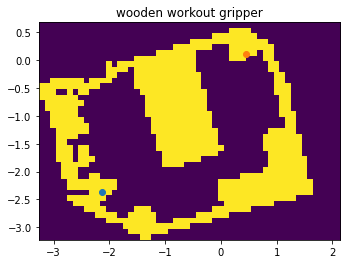

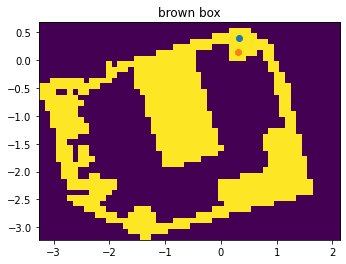

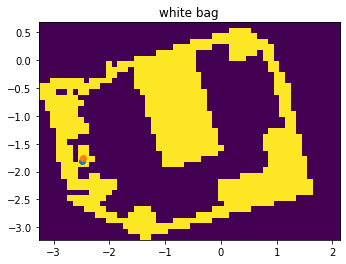

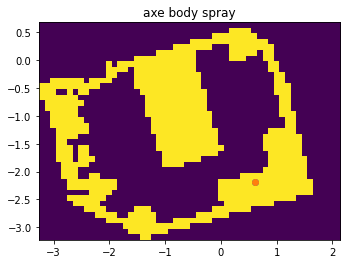

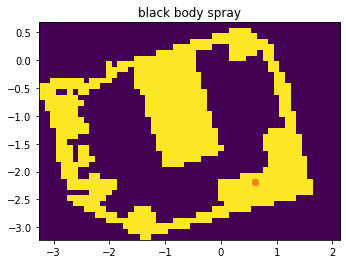

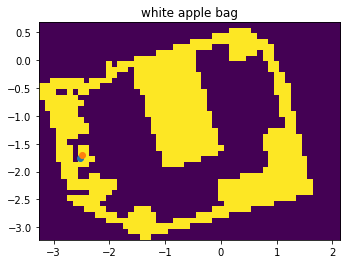

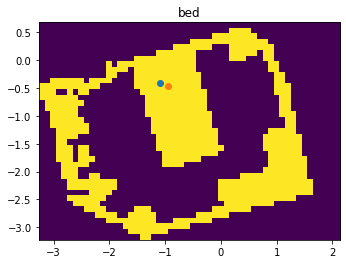

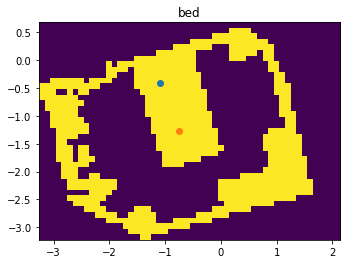

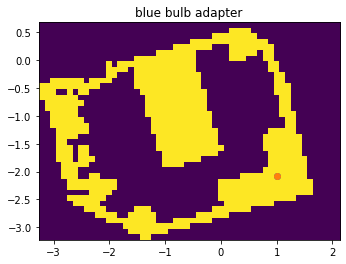

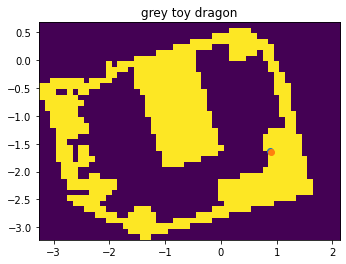

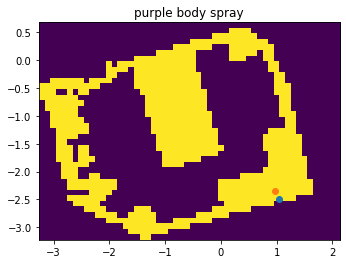

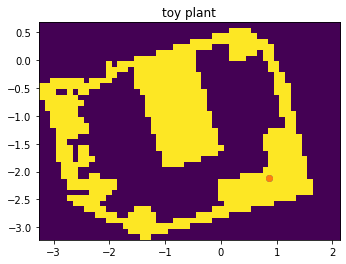

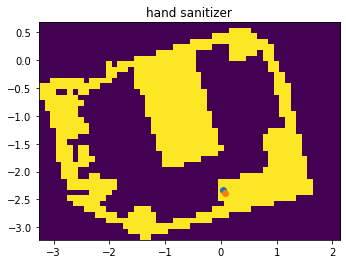

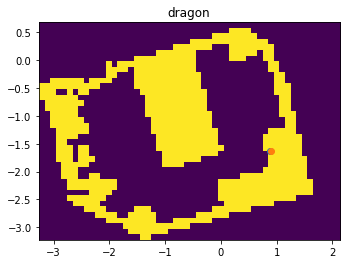

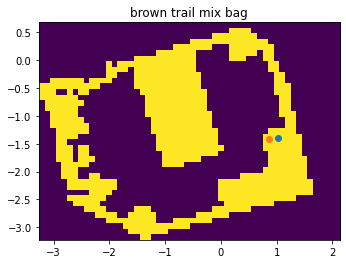

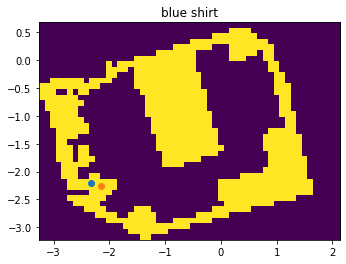

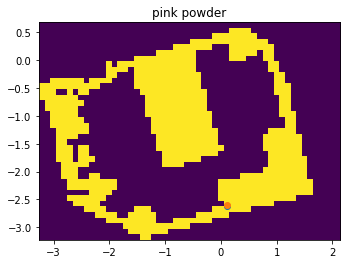

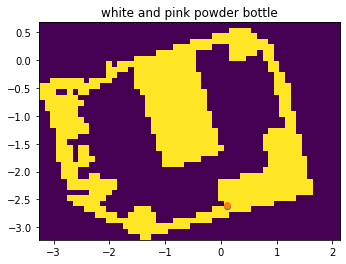

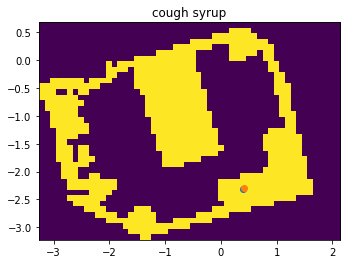

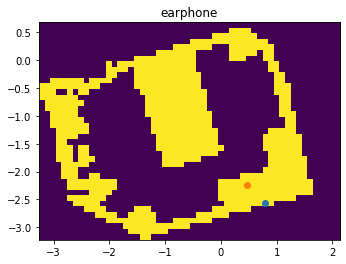

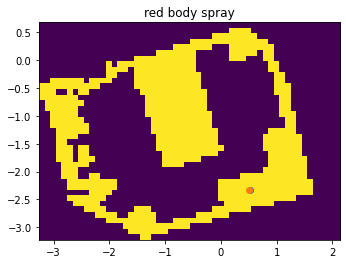

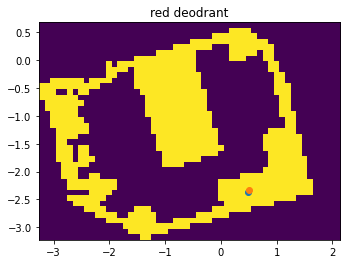

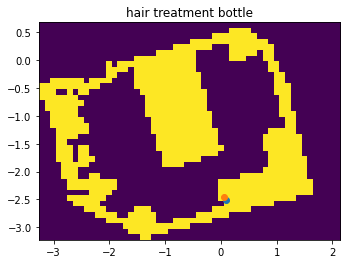

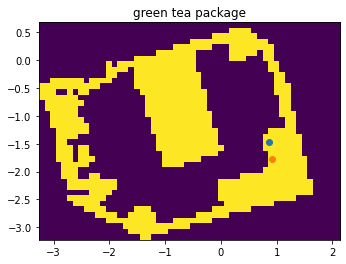

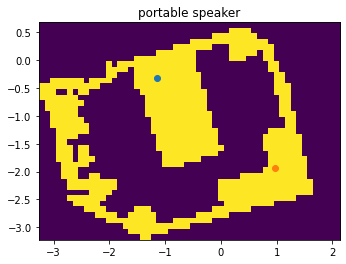

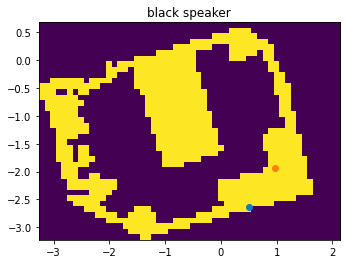

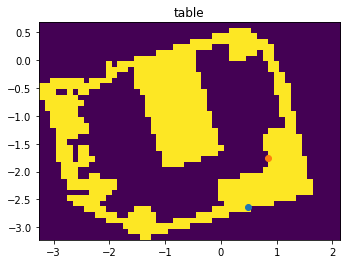

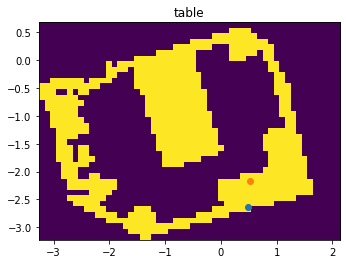

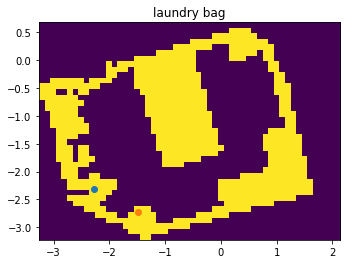

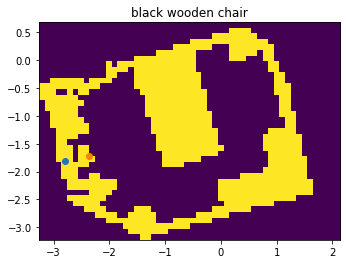

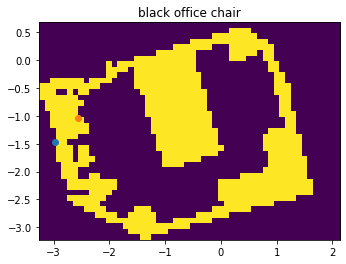

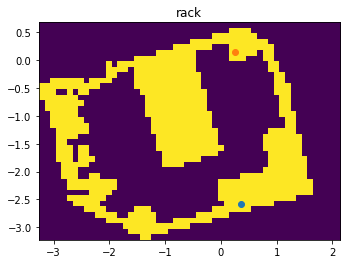

In [18]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

## OWL-ViT + CLIP

In [45]:
cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load('v2' + cfg.cache_path)

semantic_memory = load_dataset(cfg)
localizer = VoxelMapLocalizerV2(
        semantic_memory,
        owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
for idx, label in enumerate(labels):
    labels[idx] = label 
    
pred_xyzs = localizer.find_alignment_for_A(labels)
pred_xs, pred_zs, neg_pred_ys = pred_xyzs.unbind(-1)
pred_xyzs = torch.stack([pred_xs, -neg_pred_ys, pred_zs], dim = -1)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

torch.Size([32, 22614])


0.59375

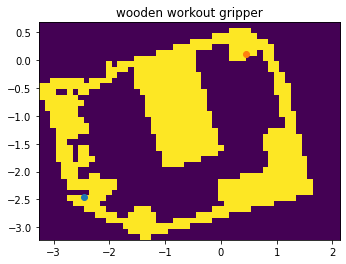

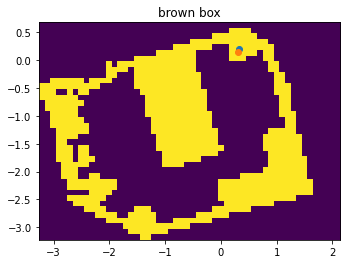

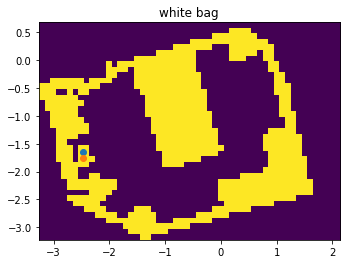

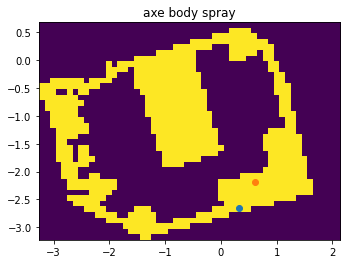

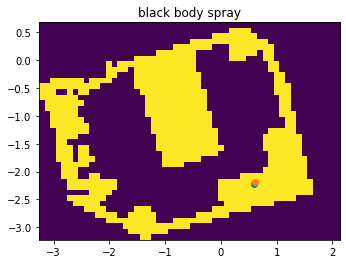

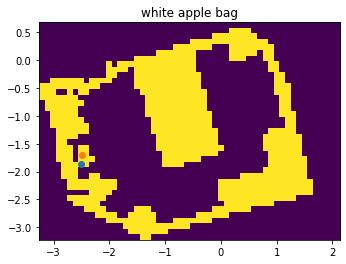

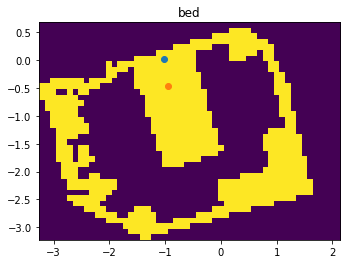

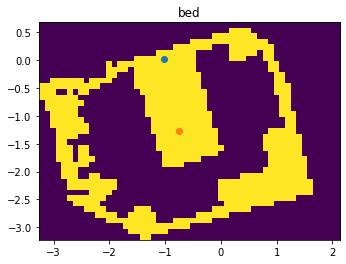

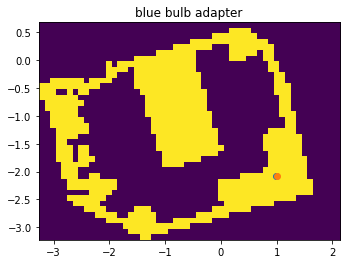

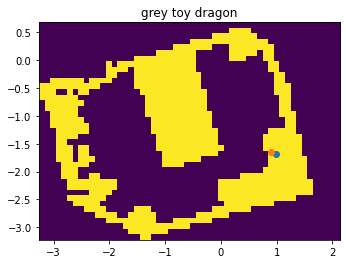

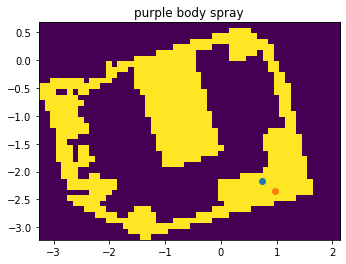

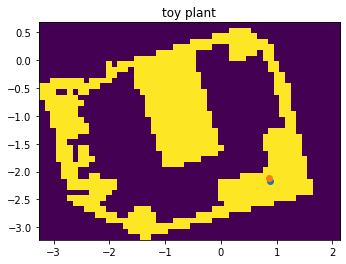

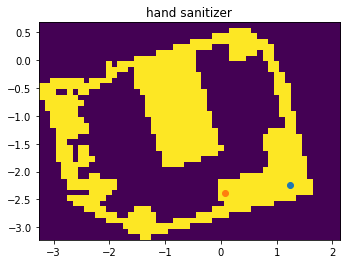

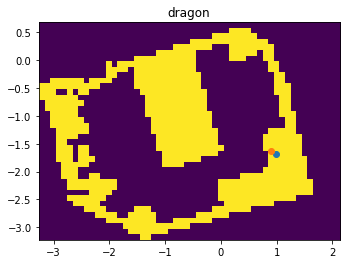

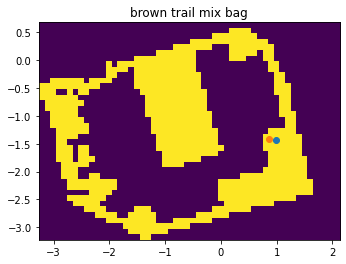

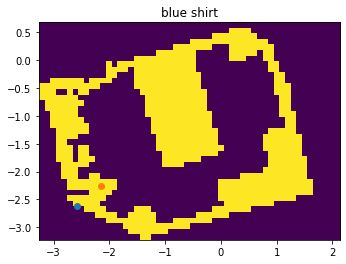

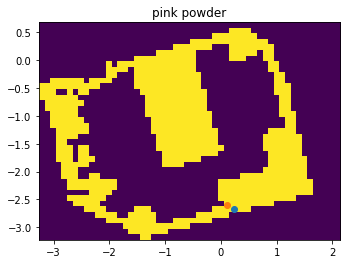

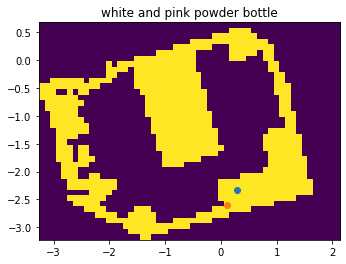

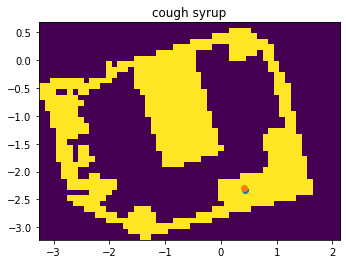

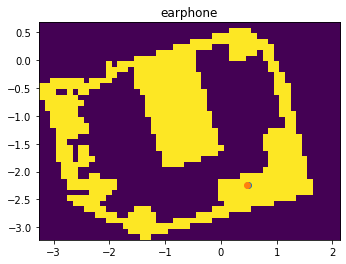

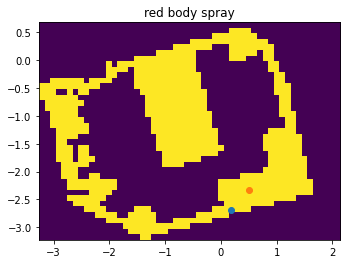

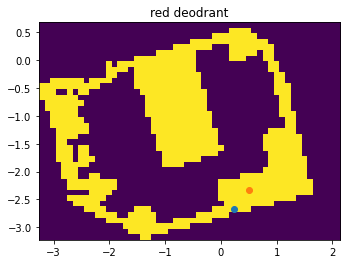

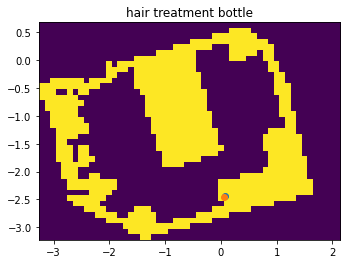

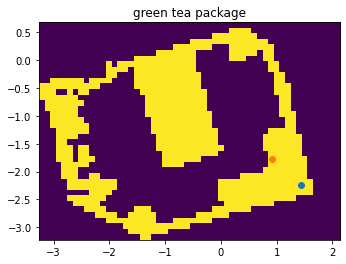

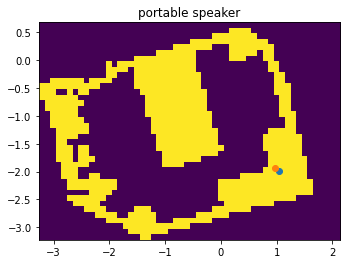

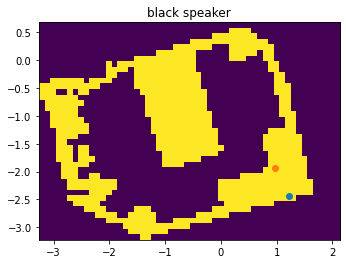

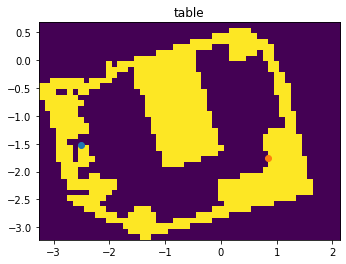

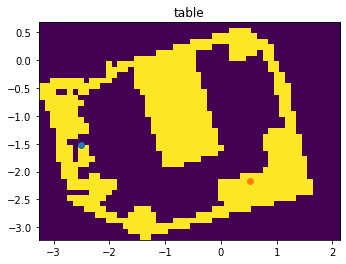

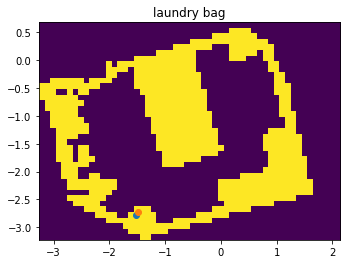

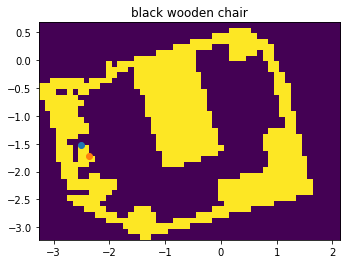

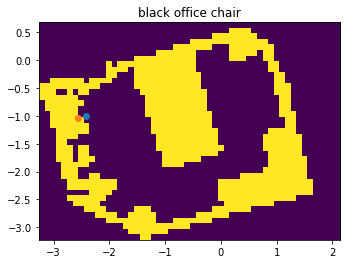

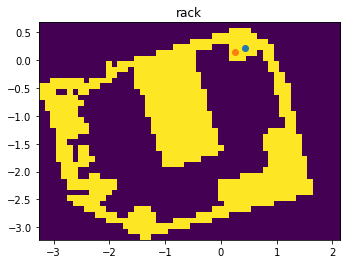

In [46]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

In [15]:
import sys
from omegaconf import OmegaConf
sys.path.append("voxel_map")
from voxel_map_localizer import VoxelMapLocalizer
from voxel_map_localizer_v3 import VoxelMapLocalizerV3
from dataloaders import (
    R3DSemanticDataset,
    OWLViTLabelledDataset,
    OWLViTLabelledDatasetV3
)

cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load('v3' + cfg.cache_path)

semantic_memory = load_dataset(cfg)
localizer = VoxelMapLocalizerV3(
        semantic_memory,
        #owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
for idx, label in enumerate(labels):
    labels[idx] = label 
    
pred_xyzs = localizer.find_alignment_for_A(labels)
pred_xs, pred_zs, neg_pred_ys = pred_xyzs.unbind(-1)
pred_xyzs = torch.stack([pred_xs, -neg_pred_ys, pred_zs], dim = -1)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

torch.Size([32, 20773])


0.59375

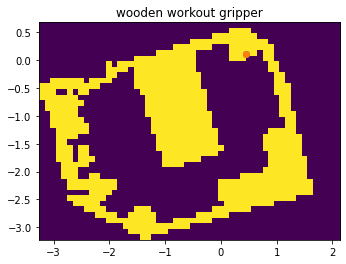

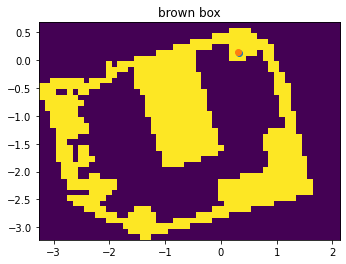

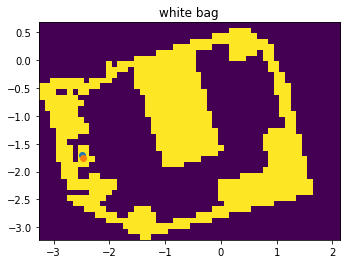

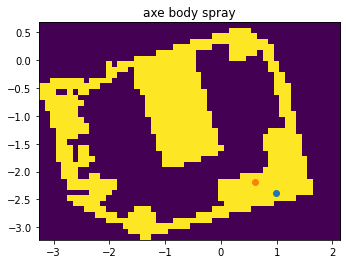

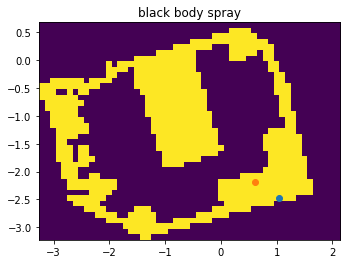

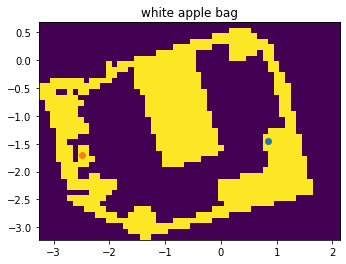

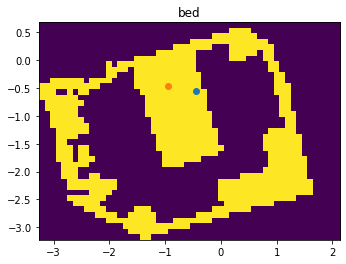

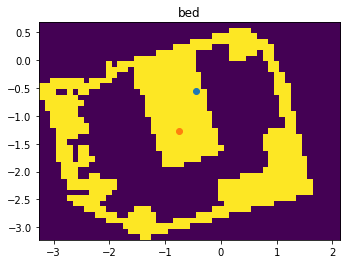

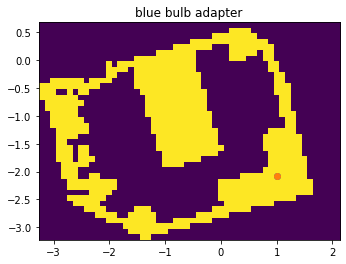

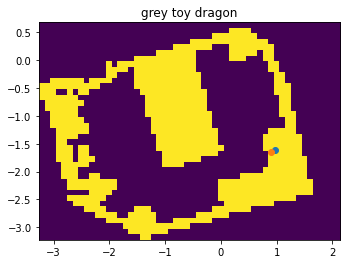

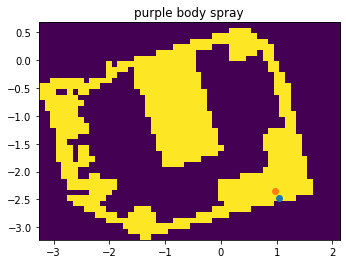

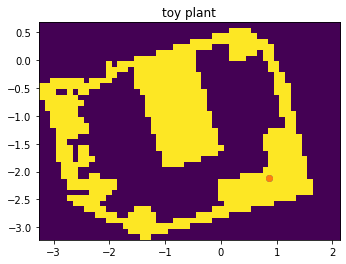

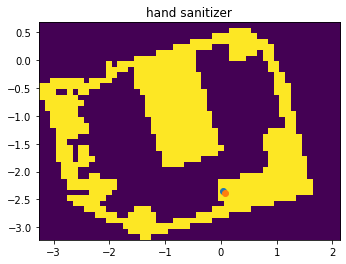

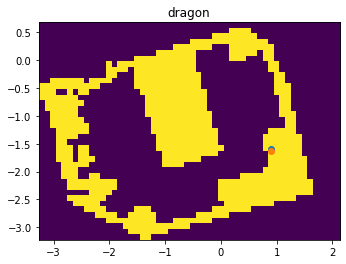

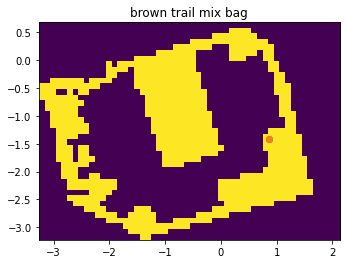

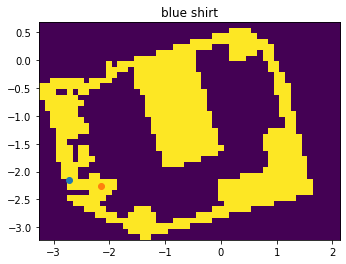

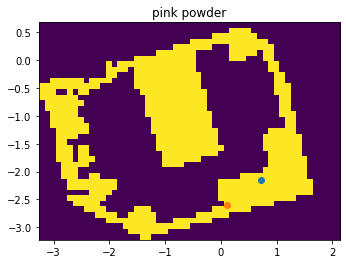

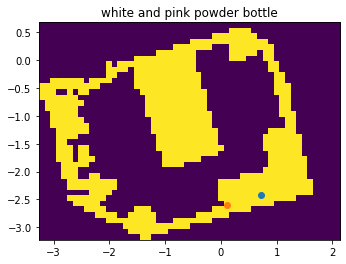

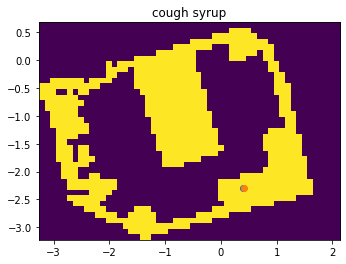

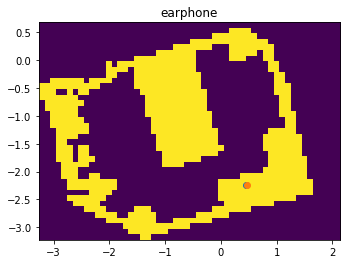

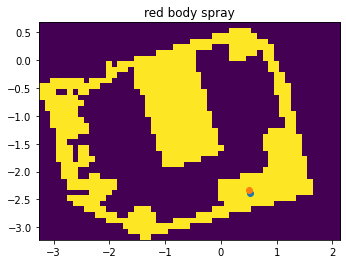

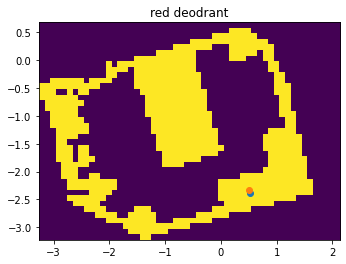

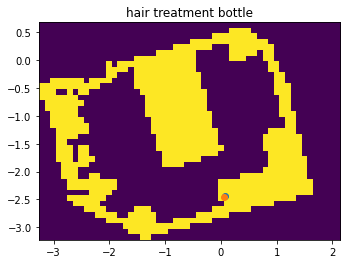

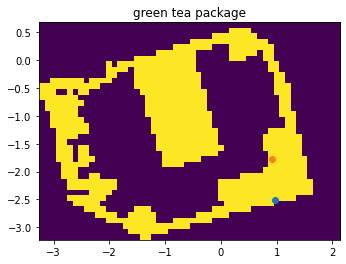

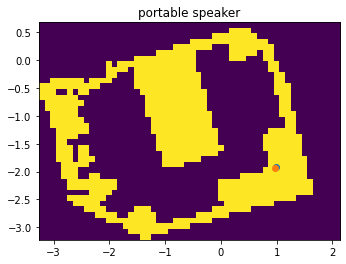

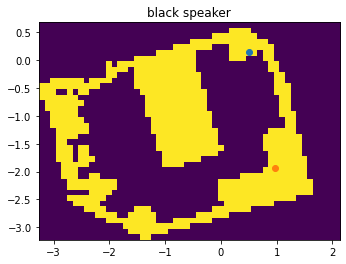

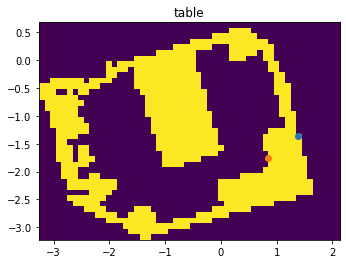

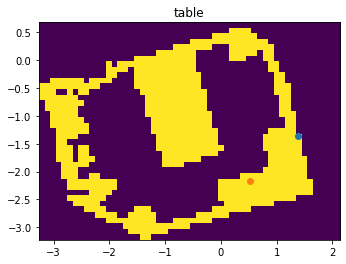

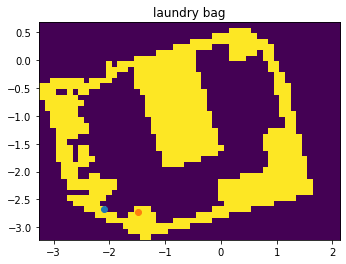

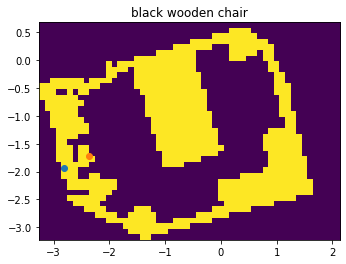

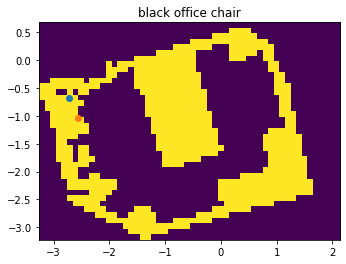

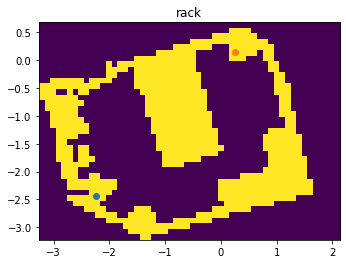

In [16]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

# Scene 2 evaluation

In [5]:
dataset = get_posed_rgbd_dataset('r3d', '/data/peiqi/r3d/LeoBedroom.r3d')

from a_star.map_util import get_ground_truth_map_from_dataset
ground_truth_map = get_ground_truth_map_from_dataset(
    dataset, 0.1, (-0.7, 1.0)
)
minx, miny = ground_truth_map.origin
(ycells, xcells), resolution = ground_truth_map.grid.shape, ground_truth_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution

Occupancy Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1232/1232 [00:02<00:00, 515.76it/s]


In [6]:
import pandas as pd

annotations = pd.read_csv('leoroom.csv')
labels = list(annotations['query'].values)
xyzs = torch.stack([torch.from_numpy(annotations['x'].values), torch.from_numpy(annotations['y'].values), torch.from_numpy(annotations['z'].values)], dim = -1)
afford = torch.from_numpy(annotations['affordance'].values)

## OK-Robot (OWL-ViT features)

In [10]:
cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load(cfg.cache_path)

semantic_memory = load_dataset(cfg)
localizer = VoxelMapLocalizer(
        semantic_memory,
        owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
for idx, label in enumerate(labels):
    labels[idx] = label 
    
pred_xyzs = localizer.find_alignment_for_A(labels)
pred_xs, pred_zs, neg_pred_ys = pred_xyzs.unbind(-1)
pred_xyzs = torch.stack([pred_xs, -neg_pred_ys, pred_zs], dim = -1)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

torch.Size([30, 16793])


0.6666666666666666

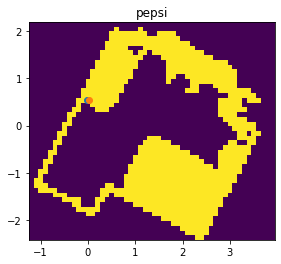

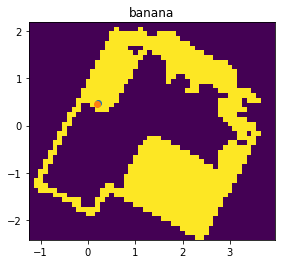

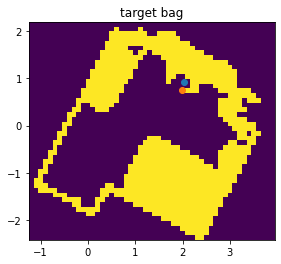

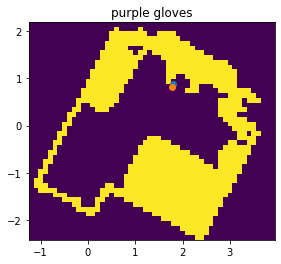

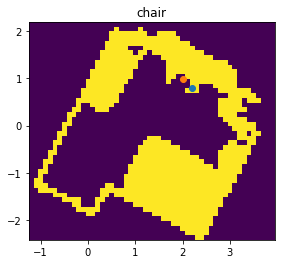

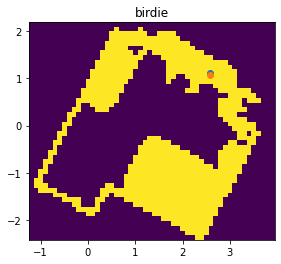

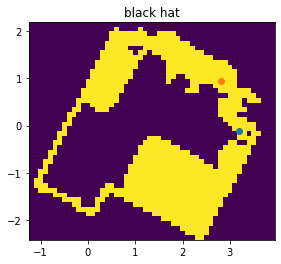

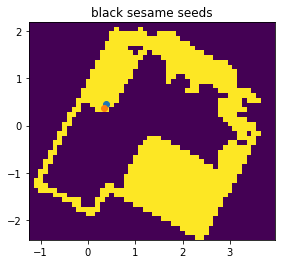

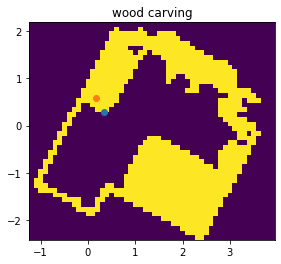

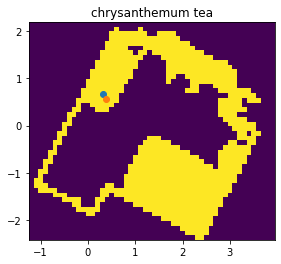

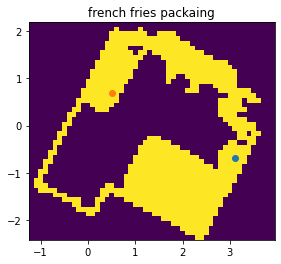

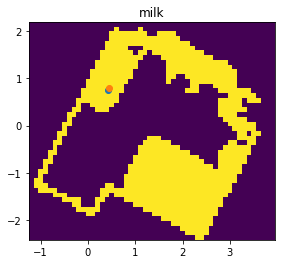

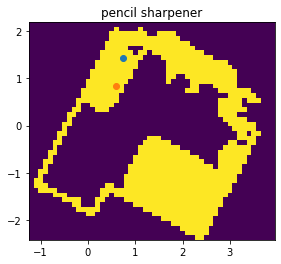

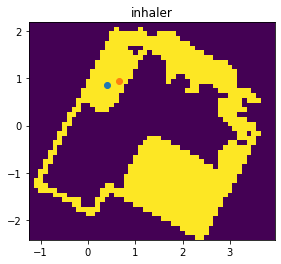

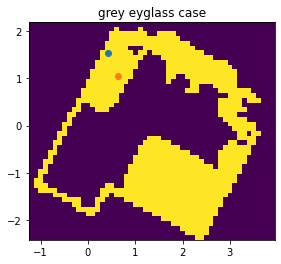

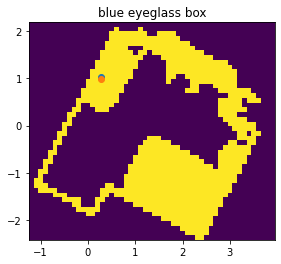

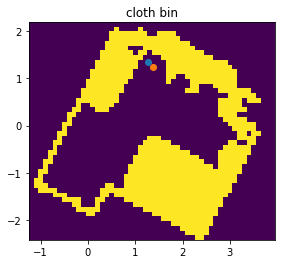

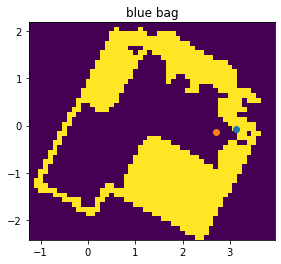

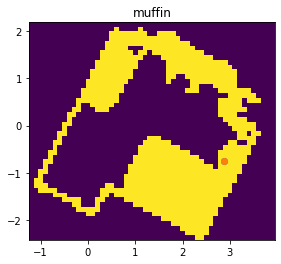

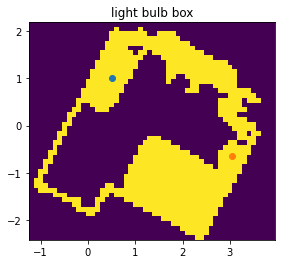

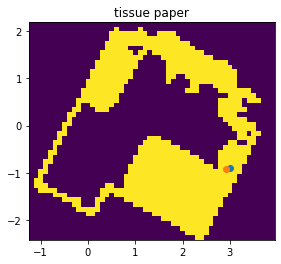

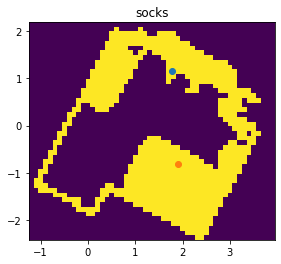

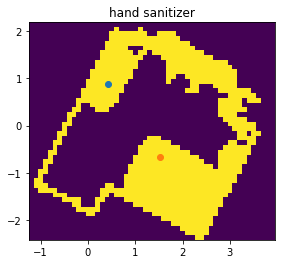

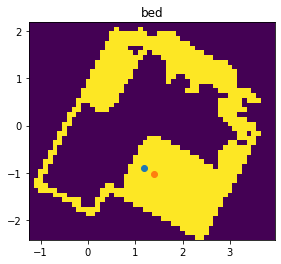

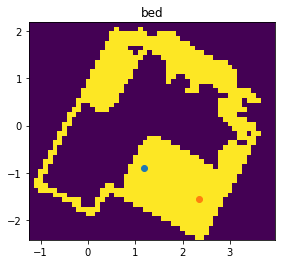

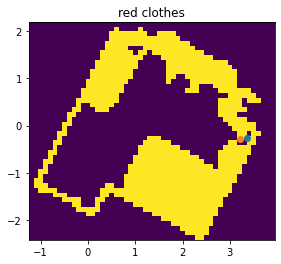

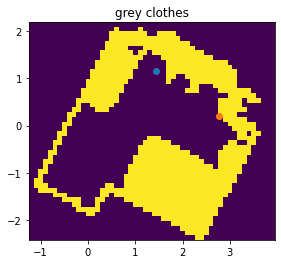

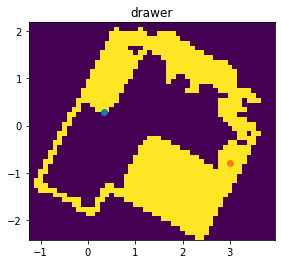

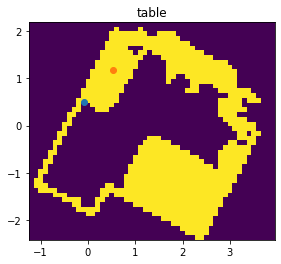

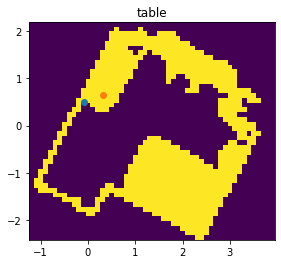

In [50]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

## MaskCLIP

In [30]:
import numpy as np
dataloader = torch.utils.data.Subset(dataset, torch.arange(0, len(dataset), 10))
voxel_pcd = VoxelizedPointcloud()
device = "cuda"
model, preprocess = clip.load("ViT-B/16", device=device)
model = model.eval().float()
#dataloader = dataset
for i in tqdm.tqdm(dataloader):
    rgb, depth, mask, intrinsics, pose = i
    _, w, h = rgb.shape
    #rgb = rgb.unsqueeze(0)
    depth = depth.unsqueeze(0)
    mask = mask.unsqueeze(0)
    point_mask = torch.empty(mask.shape, dtype=mask.dtype).fill_(False)
    intrinsics = intrinsics.unsqueeze(0)
    pose = pose.unsqueeze(0)
    batch_xyz = get_xyz_coordinates(depth.to(pose), point_mask, pose, intrinsics).reshape(w, h, -1)

    features = run_mask_clip(model, preprocess(torchvision.transforms.ToPILImage()(rgb)).unsqueeze(0).to(device), rgb.shape[-2:])[0].cpu()
    
    batch_xyz = batch_xyz[~mask[0, 0]]
    features = features[~mask[0, 0]]
    rgb = rgb.permute(1, 2, 0)[~mask[0, 0]]
    #print(features.shape, batch_xyz.shape, rgb.shape)
    voxel_pcd.add(points = batch_xyz, 
              features = features,
              rgb = rgb,)

pred_xyzs = find_alignment_over_model(labels)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

100%|█████████████████████████████████████████████████████████████████████████████████| 124/124 [00:18<00:00,  6.74it/s]


0.6333333333333333

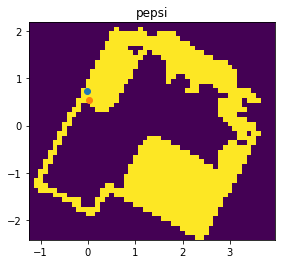

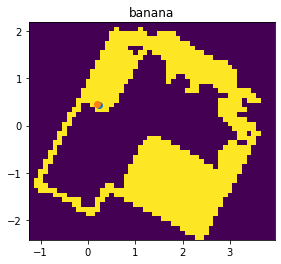

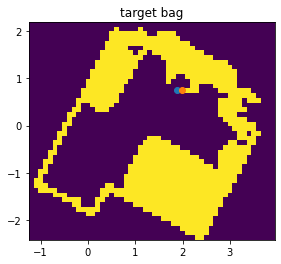

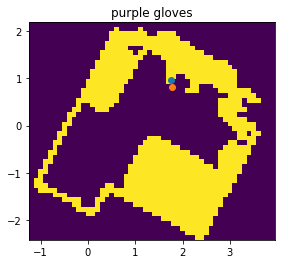

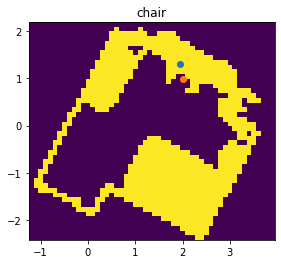

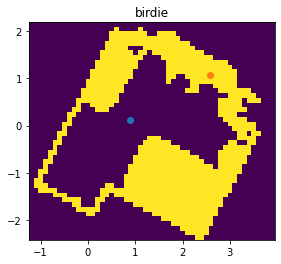

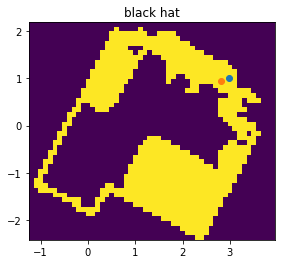

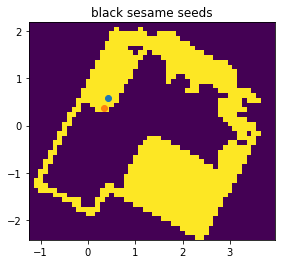

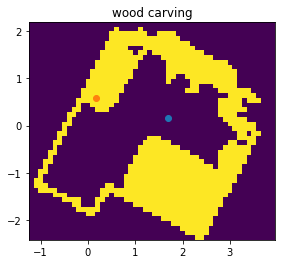

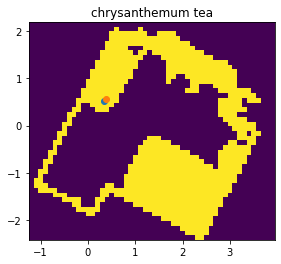

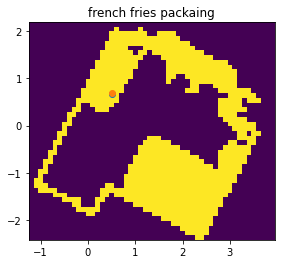

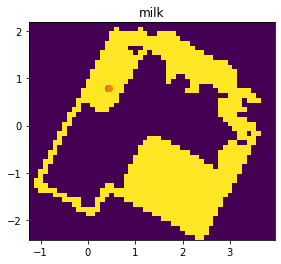

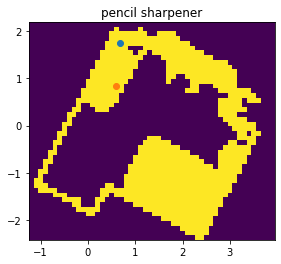

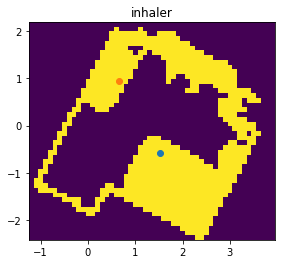

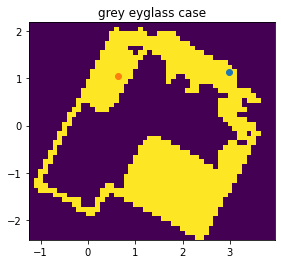

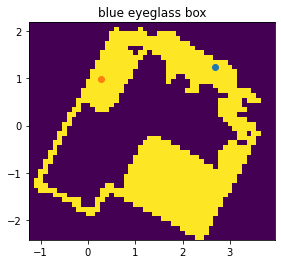

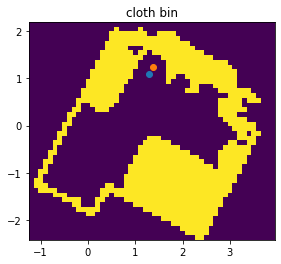

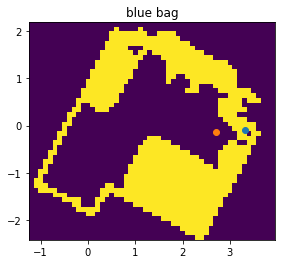

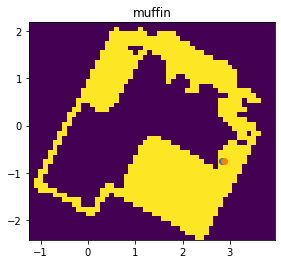

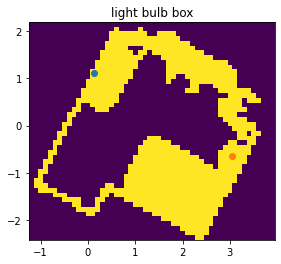

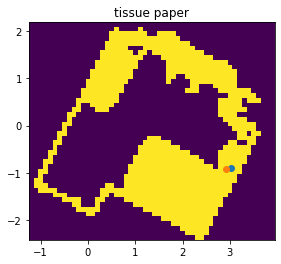

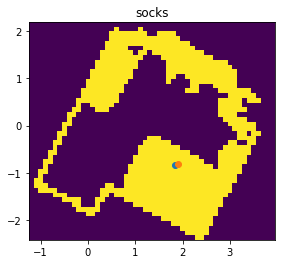

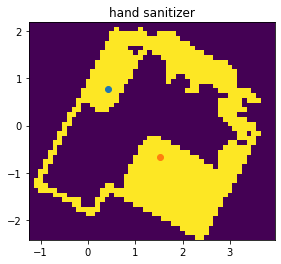

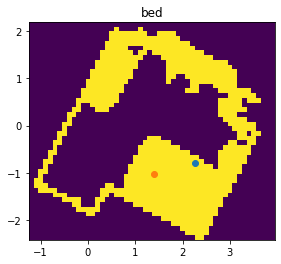

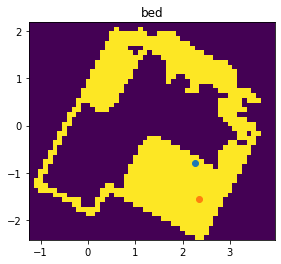

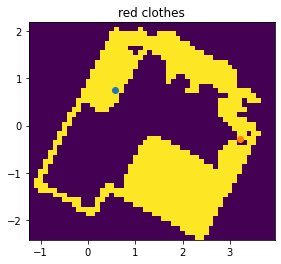

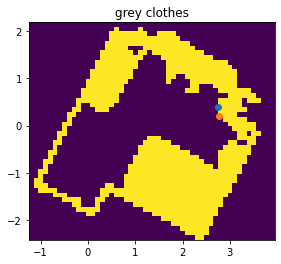

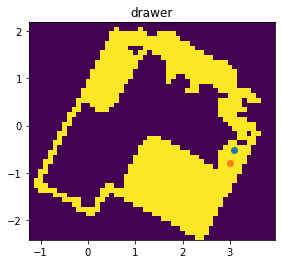

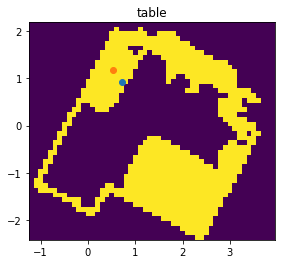

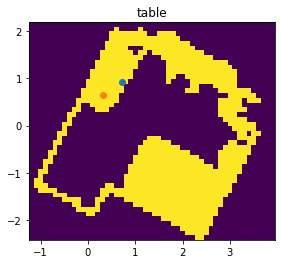

In [28]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

## OWL-ViT + CLIP

In [11]:
cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load('v2' + cfg.cache_path)

semantic_memory = load_dataset(cfg)
localizer = VoxelMapLocalizerV2(
        semantic_memory,
        owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
for idx, label in enumerate(labels):
    labels[idx] = label 
    
pred_xyzs = localizer.find_alignment_for_A(labels)
pred_xs, pred_zs, neg_pred_ys = pred_xyzs.unbind(-1)
pred_xyzs = torch.stack([pred_xs, -neg_pred_ys, pred_zs], dim = -1)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

torch.Size([30, 17504])


0.5333333333333333

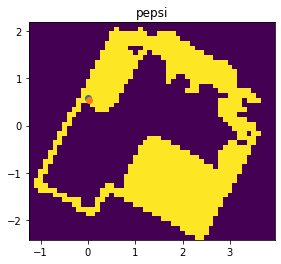

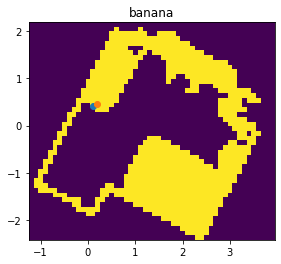

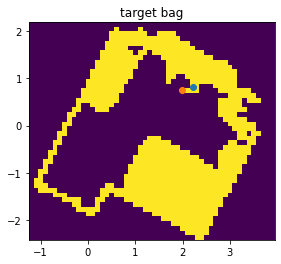

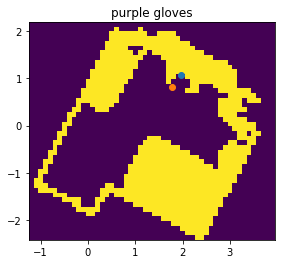

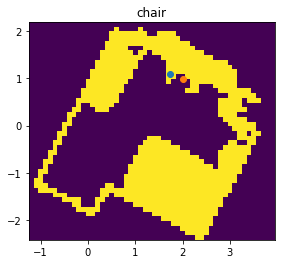

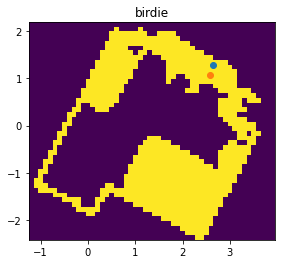

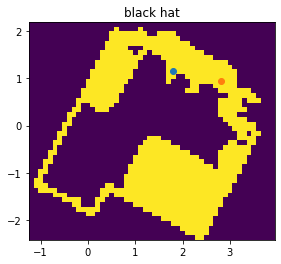

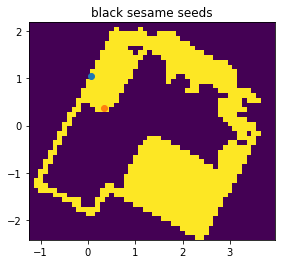

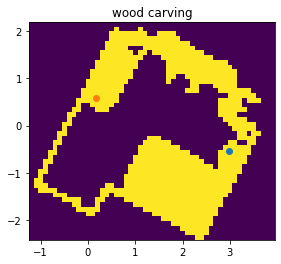

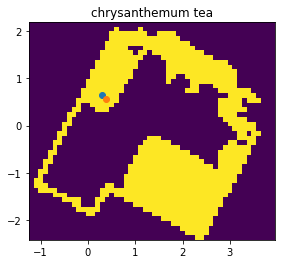

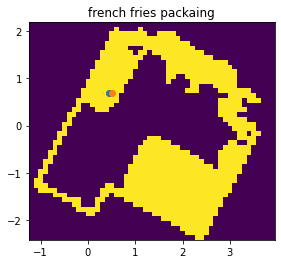

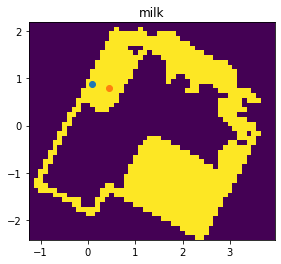

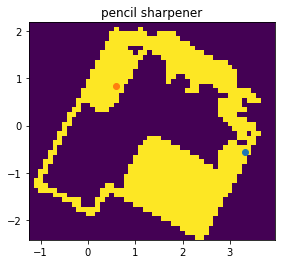

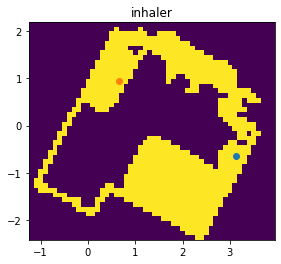

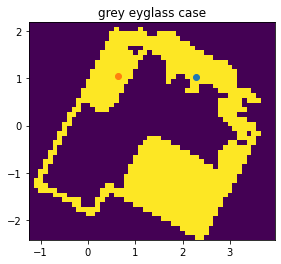

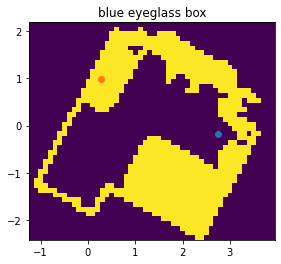

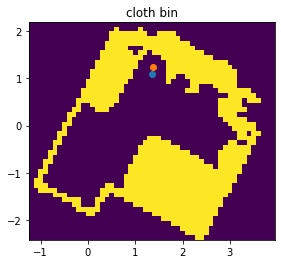

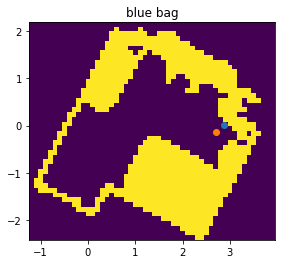

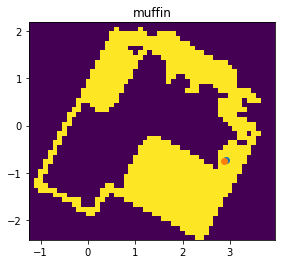

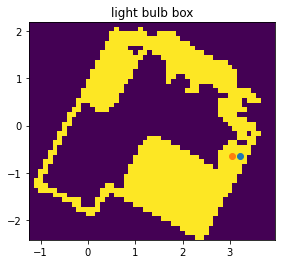

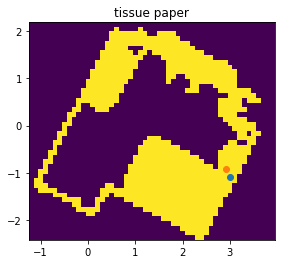

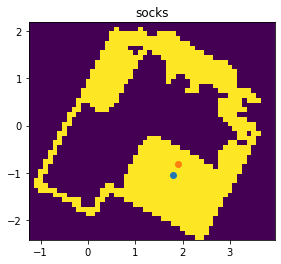

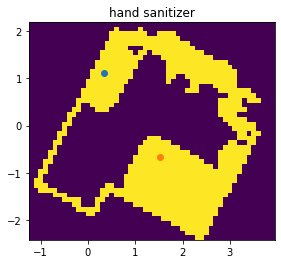

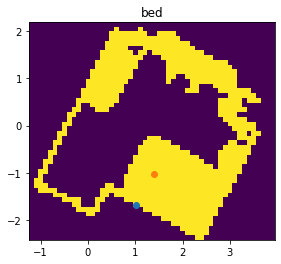

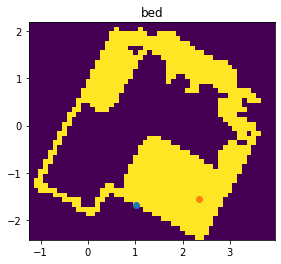

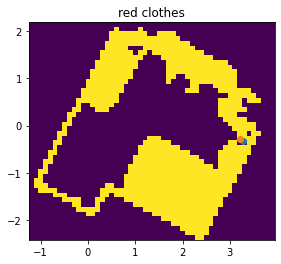

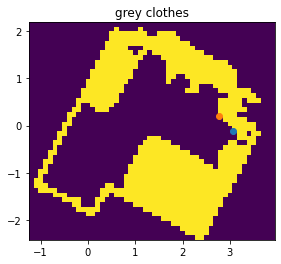

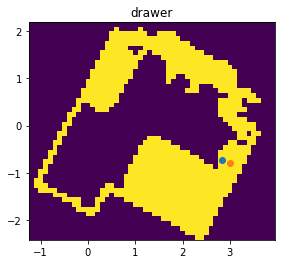

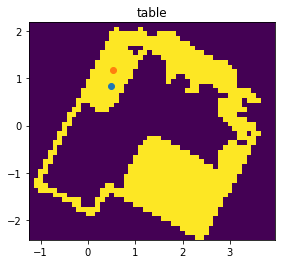

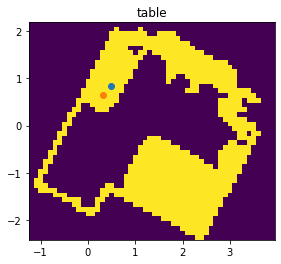

In [12]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()

In [19]:
import sys
from omegaconf import OmegaConf
sys.path.append("voxel_map")
from voxel_map_localizer import VoxelMapLocalizer
from voxel_map_localizer_v3 import VoxelMapLocalizerV3
from dataloaders import (
    R3DSemanticDataset,
    OWLViTLabelledDataset,
    OWLViTLabelledDatasetV3
)

cfg = OmegaConf.load('configs/path.yaml')

def load_dataset(cfg):
    return torch.load('v3' + cfg.cache_path)

semantic_memory = load_dataset(cfg)
localizer = VoxelMapLocalizerV3(
        semantic_memory,
        #owl_vit_config=cfg.web_models.owl,
        device=cfg.path_planning_device,
)
for idx, label in enumerate(labels):
    labels[idx] = label 
    
pred_xyzs = localizer.find_alignment_for_A(labels)
pred_xs, pred_zs, neg_pred_ys = pred_xyzs.unbind(-1)
pred_xyzs = torch.stack([pred_xs, -neg_pred_ys, pred_zs], dim = -1)
len(torch.where(torch.linalg.norm((pred_xyzs - xyzs), dim = -1) <= afford)[0]) / len(afford)

torch.Size([30, 15771])


0.6666666666666666

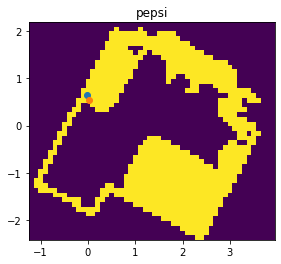

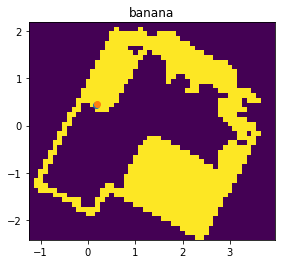

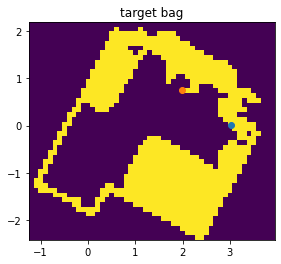

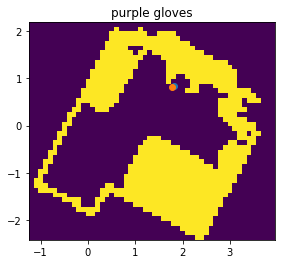

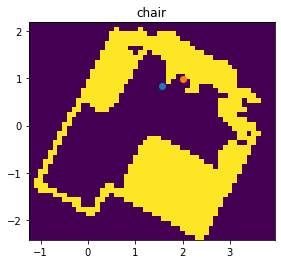

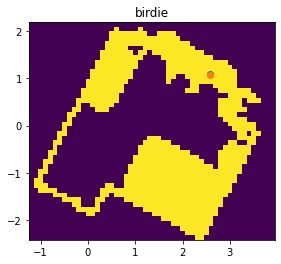

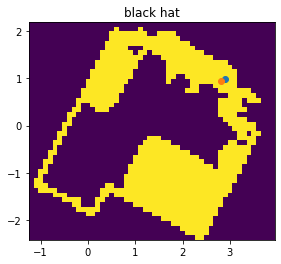

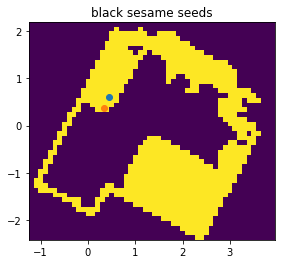

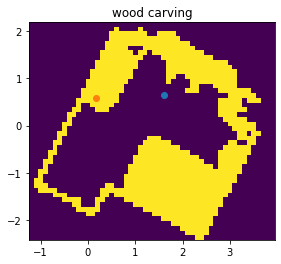

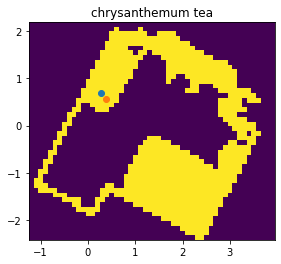

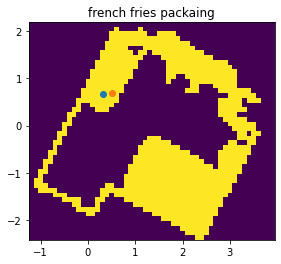

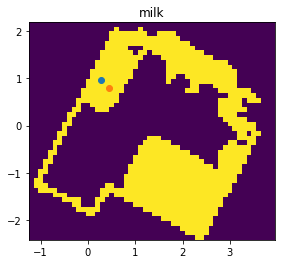

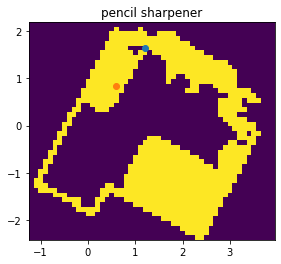

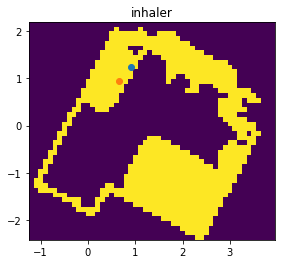

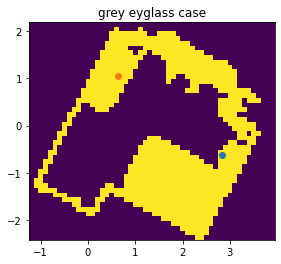

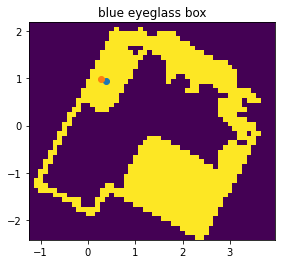

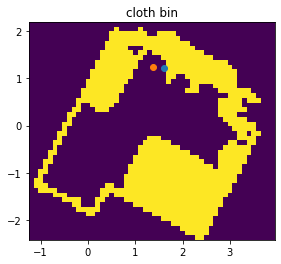

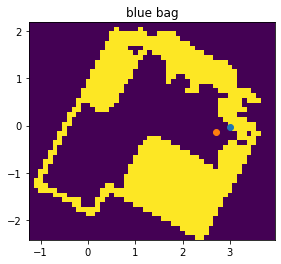

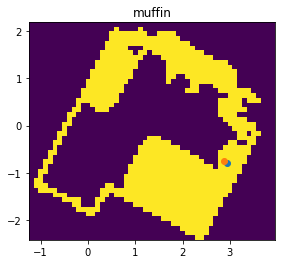

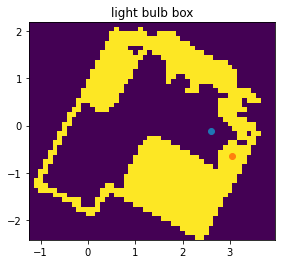

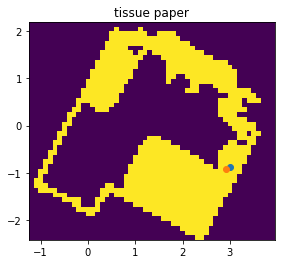

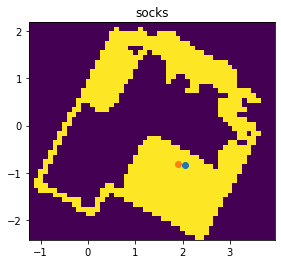

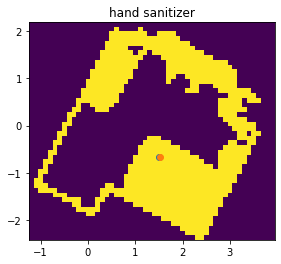

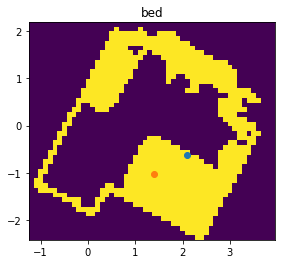

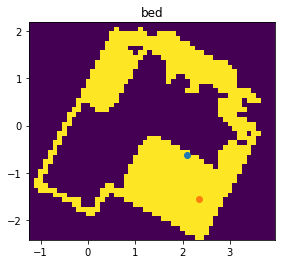

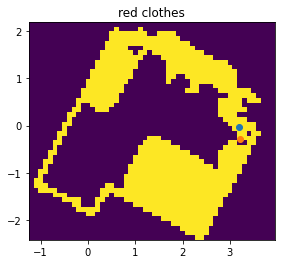

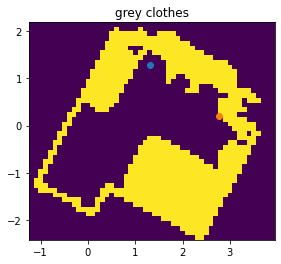

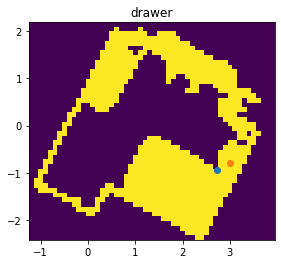

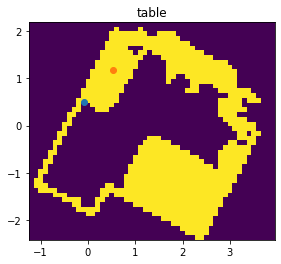

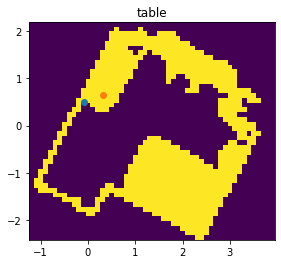

In [20]:
for idx, xyz in enumerate(pred_xyzs):
    plt.imshow(ground_truth_map.grid[::-1], extent=(minx, maxx, miny, maxy))
    plt.scatter(xyz[0], xyz[1])
    plt.scatter(xyzs[idx][0], xyzs[idx][1])
    plt.title(labels[idx])
    plt.show()